# ONLY USED TO SHOW THE VALUES WHEN TESTING WITHOUT BALANCED ACTIONS

In [1]:
import sys
sys.path.append('../')

In [2]:
# from win10toast import ToastNotifier
# toast = ToastNotifier()

In [3]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import StateActionModel
from models.utils import set_seed

from game.simulator import load_simulator_yarn

In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False
balanced_actions_test = False
n_runs = 20 if balanced_actions_test else 1

seed = 4444

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../yarnScripts'
log_path = './logs'
save_path = './saved'

graph = load_simulator_yarn('../yarnScripts').graph

## BERT Fine-tuned

In [6]:
save_model = f'{save_path}_bert'
log_dir = f'{log_path}_bert'

dict_model = dict(
    shared_out_dim=[125,75,200],
    state_layers=[[20], [30]],
    action_layers=[[20], [30]],
    out_features=[1],
    lstm_model=[False],
    bert_name=["bert-base-multilingual-cased"],
    # training parameters
)

list_model = [dict(zip(dict_model.keys(), k)) for k in itertools.product(*dict_model.values())]

In [7]:
if do_train:
    for d in tqdm(list_model):
        set_seed(seed)
        d = d.copy()

        train(
            model=StateActionModel(**d),
            dict_model=d,
            log_dir=log_dir,
            graph=graph,
            save_path=save_model,
            lr=1e-3,
            optimizer_name="adamw",
            n_epochs=80,
            batch_size=8,
            num_workers=0,
            scheduler_mode='max_val_acc',
            debug_mode=False,
            steps_save=20,
            use_cpu=False,
            freeze_bert=True,
            balanced_actions=False,
            scheduler_patience=20,
        )

#### Results

In [8]:
res_bert = test(
    graph=graph,
    save_path=save_model,
    n_runs=n_runs,
    batch_size=32,
    num_workers=0,
    debug_mode=False,
    use_cpu=False,
    save=True,
    balanced_actions=balanced_actions_test,
)

100%|██████████| 4/4 [04:11<00:00, 62.95s/it]


In [9]:
all = res_bert

In [10]:
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'shared_out_dim': 125,
 'state_layers': [30],
 'action_layers': [20],
 'out_features': 1,
 'lstm_model': False,
 'bert_name': 'bert-base-multilingual-cased',
 'train_lr': 0.001,
 'train_optimizer_name': 'adamw',
 'train_batch_size': 8,
 'train_scheduler_mode': 'max_val_mcc',
 'train_balanced_actions': False,
 'train_augment_negative': False,
 'epoch': 100,
 'train_loss': 0.28085804,
 'train_acc': 1.0,
 'val_acc': 0.9999998807907104,
 'val_mcc': 1.0,
 'train_mcc': 1.0,
 'test_mcc': 1.0,
 'test_acc': 0.9999999403953552,
 'path_name': 'saved_bert\\125_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'}

In [11]:
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'shared_out_dim': 125,
 'state_layers': [30],
 'action_layers': [20],
 'out_features': 1,
 'lstm_model': False,
 'bert_name': 'bert-base-multilingual-cased',
 'train_lr': 0.001,
 'train_optimizer_name': 'adamw',
 'train_batch_size': 8,
 'train_scheduler_mode': 'max_val_mcc',
 'train_balanced_actions': False,
 'train_augment_negative': False,
 'epoch': 100,
 'train_loss': 0.28085804,
 'train_acc': 1.0,
 'val_acc': 0.9999998807907104,
 'val_mcc': 1.0,
 'train_mcc': 1.0,
 'test_mcc': 1.0,
 'test_acc': 0.9999999403953552,
 'path_name': 'saved_bert\\125_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'}

#### df

In [12]:
all[sort_idx[0]]['dict']['path_name']

'saved_bert\\125_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'

In [13]:
df = pd.concat([*all[sort_idx[0]]['train_values'],*all[sort_idx[0]]['val_values'],*all[sort_idx[0]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,0.0,0.004996,0.0,99.500380
1,0.0,0.268380,0.0,73.162043
2,1.0,0.683785,1.0,68.378496
3,1.0,0.970110,1.0,97.010988
4,1.0,0.970110,1.0,97.010988


In [15]:
df['cert'].describe()

count    1052.000000
mean       91.415255
std        10.244138
min        64.422536
25%        88.136625
50%        96.728086
75%        98.712909
max        99.500381
Name: cert, dtype: float64

In [14]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.015533,98.446691
1.0,1.0,0.963738,96.373838


In [15]:
all[sort_idx[1]]['dict']['path_name']

'saved_bert\\75_[20]_[30]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'

In [16]:
df = pd.concat([*all[sort_idx[1]]['train_values'],*all[sort_idx[1]]['val_values'],*all[sort_idx[1]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,1.0,0.955414,1.0,95.541435
1,0.0,0.199299,0.0,80.070053
2,1.0,0.389309,0.0,61.069068
3,1.0,0.951417,1.0,95.141739
4,0.0,0.482684,0.0,51.731610


In [17]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.060083,93.991693
1.0,1.0,0.951417,95.141739


In [18]:
all[sort_idx[2]]['dict']['path_name']

'saved_bert\\200_[20]_[30]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'

In [19]:
df = pd.concat([*all[sort_idx[2]]['train_values'],*all[sort_idx[2]]['val_values'],*all[sort_idx[2]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,1.0,0.967453,1.0,96.745300
1,0.0,0.127071,0.0,87.292941
2,0.0,0.378310,0.0,62.168959
3,1.0,0.934445,1.0,93.444496
4,0.0,0.378310,0.0,62.168959


In [20]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.030431,96.956936
1.0,1.0,0.951535,95.153522


In [21]:
all[sort_idx[3]]['dict']['path_name']

'saved_bert\\125_[30]_[30]_1_False_bert-base-multilingual-cased_0.001_adamw_8_max_val_mcc_False_False_100'

In [22]:
df = pd.concat([*all[sort_idx[3]]['train_values'],*all[sort_idx[3]]['val_values'],*all[sort_idx[3]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,0.0,0.006999,0.0,99.300105
1,0.0,0.006999,0.0,99.300105
2,0.0,0.365243,0.0,63.475674
3,0.0,0.006999,0.0,99.300105
4,1.0,0.951378,1.0,95.137799


In [23]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.022097,97.790346
1.0,1.0,0.951378,95.137799


#### cm

In [24]:
cm = all[sort_idx[0]]['test_cm'][0]

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\text-games\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

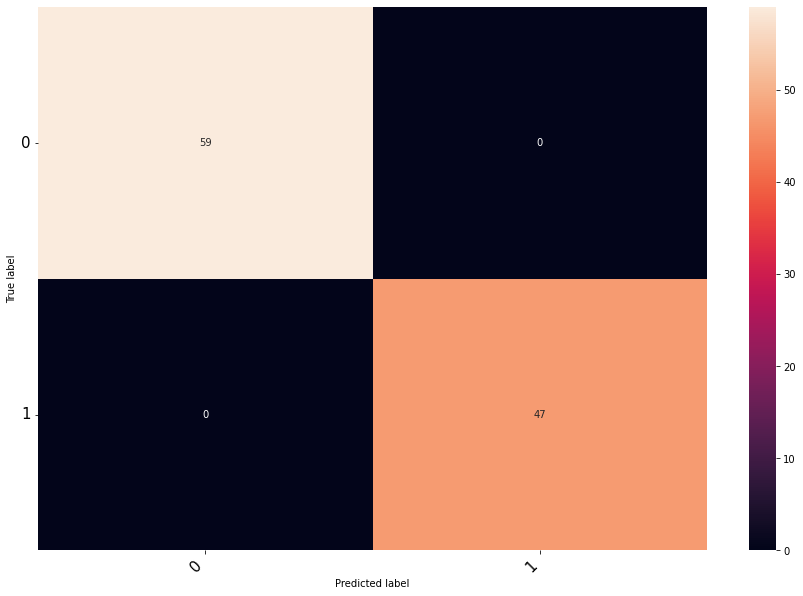

In [25]:
cm.visualize()

In [26]:
cm.class_accuracy

tensor([1.0000, 1.0000])

## BERT Fine-tuned augment negatives

In [27]:
save_model = f'{save_path}_neg'
log_dir = f'{log_path}_neg'

dict_model = dict(
    shared_out_dim=[128,64,256],
    state_layers=[[20], [30]],
    action_layers=[[20], [30]],
    # shared_out_dim=[75],
    # state_layers=[[30]],
    # action_layers=[[30]],
    out_features=[1],
    lstm_model=[False],
    bert_name=["bert-base-multilingual-cased"],
    # training parameters
)

list_model = [dict(zip(dict_model.keys(), k)) for k in itertools.product(*dict_model.values())]

In [28]:
if do_train:
    for d in tqdm(list_model):
        set_seed(seed)
        d = d.copy()

        train(
            model=StateActionModel(**d),
            dict_model=d,
            log_dir=log_dir,
            graph=graph,
            save_path=save_model,
            lr=1e-3,
            optimizer_name="adamw",
            n_epochs=180,
            batch_size=16,
            num_workers=0,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=25,
            use_cpu=False,
            freeze_bert=True,
            balanced_actions=False,
            augment_negative=True,
            scheduler_patience=35,
        )

#### Results

In [29]:
res_neg = test(
    graph=graph,
    save_path=save_model,
    n_runs=n_runs,
    batch_size=64,
    num_workers=0,
    debug_mode=False,
    use_cpu=False,
    save=True,
    balanced_actions=balanced_actions_test,
)

100%|██████████| 3/3 [02:32<00:00, 50.94s/it]


In [30]:
all = res_neg

In [31]:
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'shared_out_dim': 128,
 'state_layers': [30],
 'action_layers': [20],
 'out_features': 1,
 'lstm_model': False,
 'bert_name': 'bert-base-multilingual-cased',
 'train_lr': 0.001,
 'train_optimizer_name': 'adamw',
 'train_batch_size': 16,
 'train_scheduler_mode': 'max_val_mcc',
 'train_balanced_actions': False,
 'train_augment_negative': True,
 'train_scheduler_patience': 35,
 'val_mcc': 1.0,
 'epoch': 131,
 'train_loss': 0.50657797,
 'train_acc': 1.0,
 'val_acc': 0.9999998807907104,
 'path_name': 'saved_neg\\128_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_16_max_val_mcc_False_True_35',
 'train_mcc': 1.0,
 'test_mcc': 1.0,
 'test_acc': 0.9999999403953552}

In [32]:
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'shared_out_dim': 128,
 'state_layers': [30],
 'action_layers': [20],
 'out_features': 1,
 'lstm_model': False,
 'bert_name': 'bert-base-multilingual-cased',
 'train_lr': 0.001,
 'train_optimizer_name': 'adamw',
 'train_batch_size': 16,
 'train_scheduler_mode': 'max_val_mcc',
 'train_balanced_actions': False,
 'train_augment_negative': True,
 'train_scheduler_patience': 35,
 'val_mcc': 1.0,
 'epoch': 131,
 'train_loss': 0.50657797,
 'train_acc': 1.0,
 'val_acc': 0.9999998807907104,
 'path_name': 'saved_neg\\128_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_16_max_val_mcc_False_True_35',
 'train_mcc': 1.0,
 'test_mcc': 1.0,
 'test_acc': 0.9999999403953552}

#### Values

In [33]:
all[sort_idx[0]]['dict']['path_name']

'saved_neg\\128_[30]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_16_max_val_mcc_False_True_35'

In [34]:
df = pd.concat([*all[sort_idx[0]]['train_values'],*all[sort_idx[0]]['val_values'],*all[sort_idx[0]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,0.0,0.489740,0.0,51.025993
1,1.0,0.653802,1.0,65.380204
2,1.0,0.758273,1.0,75.827271
3,1.0,0.740997,1.0,74.099690
4,1.0,0.682429,1.0,68.242860


In [35]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.105004,89.499551
1.0,1.0,0.682429,68.242860


In [36]:
all[sort_idx[1]]['dict']['path_name']

'saved_neg\\128_[20]_[20]_1_False_bert-base-multilingual-cased_0.001_adamw_16_max_val_mcc_False_True_35'

In [37]:
df = pd.concat([*all[sort_idx[1]]['train_values'],*all[sort_idx[1]]['val_values'],*all[sort_idx[1]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,1.0,0.973708,1.0,97.370827
1,1.0,0.787412,1.0,78.741169
2,0.0,0.001031,0.0,99.896866
3,1.0,0.787412,1.0,78.741169
4,1.0,0.787412,1.0,78.741169


In [38]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.059490,94.050962
1.0,1.0,0.792588,79.258847


In [39]:
all[sort_idx[2]]['dict']['path_name']

'saved_neg\\128_[20]_[30]_1_False_bert-base-multilingual-cased_0.001_adamw_16_max_val_mcc_False_True_35'

In [40]:
df = pd.concat([*all[sort_idx[2]]['train_values'],*all[sort_idx[2]]['val_values'],*all[sort_idx[2]]['test_values']], ignore_index=True)
df.head()

,true,pred,chosen,cert
0,1.0,0.990001,1.0,99.000120
1,1.0,0.990001,1.0,99.000120
2,1.0,0.575619,1.0,57.561946
3,1.0,0.856147,1.0,85.614729
4,0.0,0.004282,0.0,99.571757


In [41]:
df.groupby('chosen').median()

,true,pred,cert
chosen,,,
0.0,0.0,0.078840,92.116040
1.0,1.0,0.901928,90.192783


#### cm

In [42]:
cm = all[sort_idx[0]]['test_cm'][0]

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\text-games\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

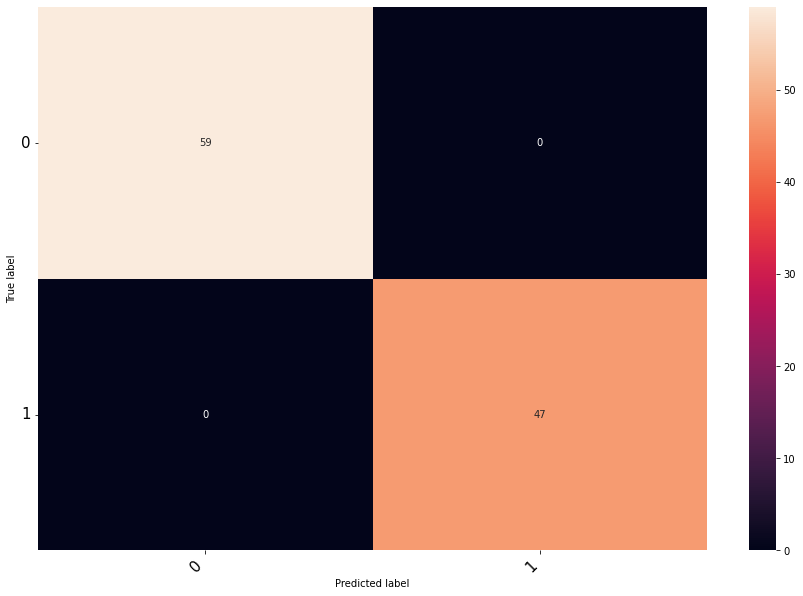

In [43]:
cm.visualize()

In [44]:
cm.class_accuracy

tensor([1.0000, 1.0000])

## BERT balanced_actions

In [45]:
save_model = f'{save_path}_balanced'
log_dir = f'{log_path}_balanced'

dict_model = dict(
    shared_out_dim=[125,75,200],
    state_layers=[[20], [30]],
    action_layers=[[20], [30]],
    out_features=[1],
    lstm_model=[False],
    bert_name=["bert-base-multilingual-cased"],
    # training parameters
)

list_model = [dict(zip(dict_model.keys(), k)) for k in itertools.product(*dict_model.values())]

In [46]:
if do_train:
    for d in tqdm(list_model):
        set_seed(seed)
        d = d.copy()

        train(
            model=StateActionModel(**d),
            dict_model=d,
            log_dir=log_dir,
            graph=graph,
            save_path=save_model,
            lr=1e-3,
            optimizer_name="adamw",
            n_epochs=4500,
            batch_size=8,
            num_workers=0,
            scheduler_mode='max_val_acc',
            debug_mode=False,
            steps_save=450,
            use_cpu=False,
            freeze_bert=True,
            balanced_actions=True,
            augment_negative=True,
            scheduler_patience=450,
        )

#### Results

In [47]:
res_test = test(
    graph=graph,
    save_path=save_model,
    n_runs=1,
    batch_size=64,
    num_workers=0,
    debug_mode=False,
    use_cpu=False,
    save=True,
)

toast.show_toast("Done")

0it [00:00, ?it/s]


NameError: name 'toast' is not defined

In [ ]:
res_test[0]

In [ ]:
all = res_test
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
all = res_test
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

#### cm

In [ ]:
cm = all[sort_idx[0]]['test_cm'][0]

In [ ]:
cm.visualize()

In [ ]:
cm.class_accuracy